In [6]:
# Define discrete action space
import numpy as np
import torch
import torch.nn as nn



STEERING_VALUES = np.linspace(-1.0, 1.0, 10)  # 10 discrete steering values
GAS_VALUES = np.linspace(0.0, 1.0, 5)  # 5 discrete gas values

DISCRETE_ACTIONS = [
    [s, g, 1 - g] for s in STEERING_VALUES for g in GAS_VALUES
]

In [7]:
len(DISCRETE_ACTIONS)

50

In [8]:
STEERING_VALUES

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [9]:
DISCRETE_ACTIONS

[[-1.0, 0.0, 1.0],
 [-1.0, 0.25, 0.75],
 [-1.0, 0.5, 0.5],
 [-1.0, 0.75, 0.25],
 [-1.0, 1.0, 0.0],
 [-0.7777777777777778, 0.0, 1.0],
 [-0.7777777777777778, 0.25, 0.75],
 [-0.7777777777777778, 0.5, 0.5],
 [-0.7777777777777778, 0.75, 0.25],
 [-0.7777777777777778, 1.0, 0.0],
 [-0.5555555555555556, 0.0, 1.0],
 [-0.5555555555555556, 0.25, 0.75],
 [-0.5555555555555556, 0.5, 0.5],
 [-0.5555555555555556, 0.75, 0.25],
 [-0.5555555555555556, 1.0, 0.0],
 [-0.33333333333333337, 0.0, 1.0],
 [-0.33333333333333337, 0.25, 0.75],
 [-0.33333333333333337, 0.5, 0.5],
 [-0.33333333333333337, 0.75, 0.25],
 [-0.33333333333333337, 1.0, 0.0],
 [-0.11111111111111116, 0.0, 1.0],
 [-0.11111111111111116, 0.25, 0.75],
 [-0.11111111111111116, 0.5, 0.5],
 [-0.11111111111111116, 0.75, 0.25],
 [-0.11111111111111116, 1.0, 0.0],
 [0.11111111111111116, 0.0, 1.0],
 [0.11111111111111116, 0.25, 0.75],
 [0.11111111111111116, 0.5, 0.5],
 [0.11111111111111116, 0.75, 0.25],
 [0.11111111111111116, 1.0, 0.0],
 [0.33333333333333326

In [10]:
class CNN_DQN(nn.Module):
    """Improved CNN Model for Deep Q-Learning"""
    def __init__(self, img_stack, DISCRETE_ACTIONS):
        super(CNN_DQN, self).__init__()

        self.DISCRETE_ACTIONS = DISCRETE_ACTIONS

        self.conv1 = nn.Conv2d(img_stack, 16, kernel_size=3, stride=2) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1) 
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1)  
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1) 
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.flatten = nn.Flatten()

        # Calculate the output shape dynamically after convolutions
        dummy_input = torch.zeros(1, img_stack, 96, 96)
        with torch.no_grad():
            conv_out_size = self._get_conv_output(dummy_input).shape[1]

        self.fc1 = nn.Linear(conv_out_size, 256) 
        self.fc2 = nn.Linear(256, len(self.DISCRETE_ACTIONS))  # Output Q-values for each discrete action

    def _get_conv_output(self, x):
        """Pass a dummy tensor to get output shape dynamically"""
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.pool2(x)

        x = torch.relu(self.conv5(x))  
        x = torch.relu(self.conv6(x))
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        return x

    def forward(self, x):
        x = self._get_conv_output(x)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output raw Q-values
        
        # print(f"out: {x.shape}")
        return x

In [15]:
cnn = CNN_DQN(4, DISCRETE_ACTIONS=DISCRETE_ACTIONS)

In [16]:
cnn

CNN_DQN(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def load_and_process_csv(file_path):
    """Loads the CSV file, extracts episode and reward data."""
    df = pd.read_csv(file_path, header=None, dtype=str)
    
    cleaned_data = []
    for _, row in df.iterrows():
        row_str = " ".join(row.astype(str))  # Convert row to string
        match = re.search(r"(\d+)\s+tensor\(\[([-+]?[0-9]*\.?[0-9]+)\]", row_str)
        if match:
            episode = int(match.group(1))
            reward = float(match.group(2))
            cleaned_data.append((episode, reward))
    
    return pd.DataFrame(cleaned_data, columns=["Episode", "Reward"])

def plot_training_progress(df, file_name, window_size=10):
    """Plots DQN training progress with a moving average."""
    df["Moving_Avg"] = df["Reward"].rolling(window=window_size).mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(df["Episode"], df["Reward"], color='orange', alpha=0.5, label="Raw Rewards")
    plt.plot(df["Episode"], df["Moving_Avg"], color='red', linewidth=2, label=f"Moving Avg ({window_size} episodes)")
    
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("DQN Training Progress with Moving Average")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{file_name}_training_reward.png", dpi=300, bbox_inches='tight')
    plt.show()

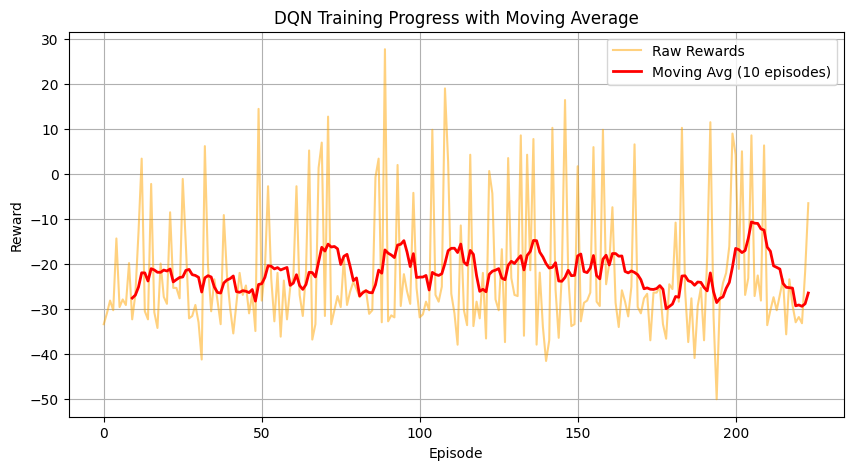

In [4]:
file_path = "C:/Users/cyril/Downloads/CNN_DQN_20250210215238(2).csv"  # Replace with your actual file path
file_name = file_path.split('/')[-1].split('.')[0]
df = load_and_process_csv(file_path)
plot_training_progress(df, file_name)